<a href="https://colab.research.google.com/github/alexisjkim/conformal_prediction_limitations/blob/main/Conformal_Prediction_Limitations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [251]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset, TensorDataset
import torchvision

import pandas as pd
import cv2


In [252]:
# loading data and splitting into train, calibration, test sets

batch_size = 128

# this dataset has the training data from MNIST; will be split into training and calibration sets
mnist_train_set = torchvision.datasets.MNIST(root='./datasets/',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)



# this dataset has the test data from MNIST
mnist_test_dataset = torchvision.datasets.MNIST(root='./datasets',
                                          train=False,
                                          transform=torchvision.transforms.ToTensor())


train_percentage = 0.8 # this percentage of the training data set stays in the train set; the rest becomes part of the calibration set

train_size = int(train_percentage *len(mnist_train_set))
calibration_size = len(mnist_train_set) - train_size

mnist_train_set, mnist_cal_set = random_split(mnist_train_set, [train_size, calibration_size])

# Data loader
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

# We use drop_last=True to avoid the case where the data / batch_size != int

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print("SIZES OF DATASETS: ")
print("training set: ", len(mnist_train_loader.dataset))
print("calibration set: ", len(mnist_cal_loader.dataset))
print("testing set: ", len(mnist_test_loader.dataset))

SIZES OF DATASETS: 
training set:  48000
calibration set:  12000
testing set:  10000


In [253]:
# class for our neural network

class TwoLayerNetPiped(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        Parameters:
            D_in - dimensions of inputs
            H - number of hidden units per layer
            D_out - dimensions of outputs
        """
        # initialzing the parent object (important!)
        super(TwoLayerNetPiped, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        Parameters:
            x - tensor of inputs (shape: [BATCH_SIZE, D_in])
        """
        return self.pipe(x)

In [201]:
# Setting up the model

# hyper-parameters:
num_epochs = 1
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create model, send it to device
model = TwoLayerNetPiped(D_in=28*28, H=256, D_out=10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [255]:
# Train the model, given a training set in DataLoader form

def train_model(loader):

    model.train()  # training mode
    total_step = len(loader)
    start_time = time.time()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            # each i is a batch of 128 samples
            images = images.to(device).view(batch_size, -1)  # represent images as column vectors
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize - ALWAYS IN THIS ORDER!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), time.time() - start_time))

In [256]:
train_model(mnist_train_loader)

Epoch [1/1], Step [100/375], Loss: 0.2495, Time: 0.6368 secs
Epoch [1/1], Step [200/375], Loss: 0.1137, Time: 1.0876 secs
Epoch [1/1], Step [300/375], Loss: 0.2559, Time: 1.5392 secs


In [259]:
# Test the model

def test_model(model, test_loader):

  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance), or use:
  with torch.no_grad(): # "don't keep track of the gradients" ,can also use .detach()
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device).view(images.size(0), -1) #image.size(0) returns batch size
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


test_model(model, mnist_test_loader)

Test Accuracy of the model on the 10000 test images: 95.58 %


In [205]:


def get_probabilities_and_predictions(loader):
    probs_list = []
    preds_list = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device).view(images.size(0), -1)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim = 1) #1 corresponds to columns
            #the prediction outputs the index of what it thinks the class is
            #the omitted term is the value
            _, predictions = torch.max(outputs.data, 1) #get the index of the highest output
            # Append to lists
            preds_list.extend(predictions.cpu().numpy())
            probs_list.extend(probabilities.cpu().numpy())

    return probs_list, preds_list

Conformal prediction starts here

In [206]:
#Calibration
def get_cal_probs(loader):
  cal_probs = []
  cal_preds = []
  cal_probs, cal_preds = get_probabilities_and_predictions(loader)
 # print("cal_probs:", cal_probs[:5])
 # print("cal_preds:", cal_preds[:5])

  cal_scores = []
  for prob, true_label in zip(cal_probs, cal_preds): #prob is the probability and true_label is index of pred
    true_class_prob = prob[true_label] #the corresponding lists with their prob function getting the most predicted class
    cal_scores.append(1 - true_class_prob) #s_i score

  cal_scores = np.array(cal_scores)
  sorted_scores = np.sort(cal_scores) #probabilities

  return sorted_scores


In [207]:


def get_quantile(scores, alpha, loader):
  n = 0
  for _, labels in loader:
    n += labels.size(0)
    
  q_level = math.ceil((1 - alpha) * (n + 1)) / n

  
# print(f"Adjusted quantile level: {q_level}")
  return np.percentile(scores, (1 - alpha) * 100)




In [208]:
alpha = 0.05
sorted_scores = get_cal_probs(mnist_cal_loader)
threshold = get_quantile(sorted_scores, alpha, mnist_cal_loader) #for the calibration set
print(threshold)

0.4507501900196076


In [209]:
#we know the conformal prediciton model takes in probabilities until it reaches the
#the threshold q hat
#the threshold is q hat (that quantile value)

def conformal_prediction(probabilities, threshold):
    predictions = []
    for prob in probabilities:
        sorted_indices = np.argsort(prob)[::-1]
        total = 0.0
        prediction = []
        for i in sorted_indices:
            total += prob[i]
            prediction.append(i)
            if total > 1 - threshold: #we do 1 - threshold because we want to observe the right side as we are adding in ascending order
                break
        predictions.append(prediction)
    return predictions





In [210]:
#evaluation
def evaluate_and_print(observed_labels, conformal_prediction, predicted, start_row, end_row, should_i_print=True):
  formatted_output = pd.DataFrame({
    'observed labels': observed_labels,
    'confromal prediction set': conformal_prediction,
    'prediction': predicted
  })


  #evaluation metric
  hits = 0
  total = len(observed_labels)
  for i in range(len(observed_labels)):
    conf_pred_row = conformal_prediction[i]
    observed = observed_labels[i]

    if observed in conf_pred_row:
      hits += 1

  if (should_i_print == True):
    print("the prediction was in the set ", hits/total *100, " percent of the time")
    print(formatted_output[start_row:end_row])

  return hits / total * 100


In [211]:
#getting observed label functions
def get_observed_labels(loader):
    observed_labels = []
    with torch.no_grad():
        for images, labels in loader:
            observed_labels.extend(labels.cpu().numpy())
    return observed_labels

In [212]:
#evaluating our testing data set

test_observed_labels = get_observed_labels(mnist_test_loader)

test_probs = []
test_preds = []
test_probs, test_preds = get_probabilities_and_predictions(mnist_test_loader)


conformal_predictions = conformal_prediction(test_probs, threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
evaluate_and_print(test_observed_labels, conformal_predictions, test_preds, 300, 450)



The conformal prediction accuracy based on training data and testing data from the same distribution is:
the prediction was in the set  95.38  percent of the time
     observed labels confromal prediction set  prediction
300                4                   [6, 1]           6
301                7                      [7]           7
302                1                      [1]           1
303                2                      [2]           2
304                4                      [4]           4
..               ...                      ...         ...
445                6                      [0]           0
446                6                      [6]           6
447                4                      [4]           4
448                9                      [8]           8
449                3                      [3]           3

[150 rows x 3 columns]


95.38

In [245]:
# PART 2: reducing the size of the calibration set

mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=False, drop_last=True)

max_calibration_size = len(mnist_cal_loader.dataset)
alpha = 0.05

print("max cal size: ", max_calibration_size)

reduced_loader = mnist_cal_loader

cal_set_size = []
accuracy_scores = []

for i in range(100, 10, -1):

    print(i)
    sorted_scores = get_cal_probs(reduced_loader)
    threshold = get_quantile(sorted_scores, alpha, reduced_loader)

    test_observed_labels = get_observed_labels(reduced_loader)

    test_probs = []
    test_preds = []
    test_probs, test_preds = get_probabilities_and_predictions(reduced_loader)

    conformal_predictions = conformal_prediction(test_probs, threshold)

    cal_set_size.append(i)
    accuracy_scores.append(evaluate_and_print(test_observed_labels, conformal_predictions, test_preds, 300, 450,True))

    reduced_dataset = Subset(reduced_loader.dataset, list(range(i)))
    reduced_loader = DataLoader(reduced_dataset, batch_size=batch_size, shuffle=False)
        

max cal size:  12000
100
the prediction was in the set  95.30409946236558  percent of the time
     observed labels confromal prediction set  prediction
300                6                      [6]           6
301                1                      [1]           1
302                3                      [3]           3
303                2                      [2]           2
304                3                      [3]           3
..               ...                      ...         ...
445                8                      [7]           7
446                2                      [2]           2
447                2                      [2]           2
448                7                      [7]           7
449                6                      [6]           6

[150 rows x 3 columns]
99
the prediction was in the set  91.0  percent of the time
Empty DataFrame
Columns: [observed labels, confromal prediction set, prediction]
Index: []
98
the prediction was in the set  

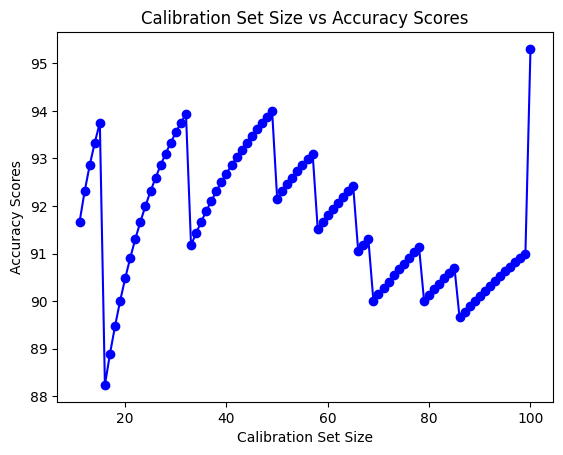

In [246]:
plt.plot(cal_set_size, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')  # Plot the data
plt.title('Calibration Set Size vs Accuracy Scores')
plt.xlabel('Calibration Set Size')
plt.ylabel('Accuracy Scores')
plt.show()

Repeating the experiment with test data that doesn't match the calibration set.

Functions for Blurring

In [105]:
def blur_images(image):
  return torch.tensor(cv2.blur(image.numpy(), (30, 30)))

In [106]:
#get blurred data
#blur the images
def get_blurred_data(loader):
    blurred_images = []
    blurred_labels = []

    # adding blur to every image in the training set
    with torch.no_grad():
        for images, labels in loader:
            for i in range(len(images)):
                blurred_image = blur_images(images[i])
                blurred_images.append(blurred_image)
                blurred_labels.append(labels[i])

    blurred_images = torch.stack(blurred_images)
    blurred_labels = torch.tensor(blurred_labels)

    return blurred_images, blurred_labels

In [107]:
def create_blur_loader(blurred_images, blurred_labels):
    # Create a TensorDataset and DataLoader for the blurred images
    blurred_dataset = TensorDataset(blurred_images, blurred_labels)
    blurred_loader = DataLoader(blurred_dataset, batch_size=128, shuffle=False)
    return blurred_loader

In [108]:
#testing our model on blurred images

blur_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blur_loader)

blurred_images, blurred_labels = get_blurred_data(blur_loader)
blurred_loader = create_blur_loader(blurred_images, blurred_labels)
blur_probs = []
blur_preds = []
blur_probs, blur_preds = get_probabilities_and_predictions(blurred_loader)
'''''
blur_probs = []
blur_pred = []

# Flatten images for model input
blurred_images = blurred_images.view(len(blurred_images), -1).to(device)

#find probabilities and predictions
with torch.no_grad():
  outputs = model(blurred_images)
  probabilities = torch.nn.functional.softmax(outputs, dim = 1)
  _, blur_pred = torch.max(outputs.data, 1)


blur_preds = blur_pred.cpu().numpy()
blur_probs = probabilities.cpu().numpy()'''


conformal_predictions = conformal_prediction(blur_probs, threshold)
print("This is the conformal prediction accuracy based on training data and testing data from different distributions. \nThe training data contains normal images while the testing data were all blurred:")
evaluate_and_print(observed_labels, conformal_predictions, blur_preds, 10, 200)



This is the conformal prediction accuracy based on training data and testing data from different distributions. 
The training data contains normal images while the testing data were all blurred:
the prediction was in the set  22.71  percent of the time
     observed labels confromal prediction set  prediction
10                 0                [3, 6, 5]           3
11                 6                   [5, 3]           5
12                 9                      [3]           3
13                 0                   [3, 2]           3
14                 1                      [1]           1
..               ...                      ...         ...
195                3                [3, 2, 5]           3
196                1                      [1]           1
197                6                      [3]           3
198                4                   [3, 7]           3
199                2                      [3]           3

[190 rows x 3 columns]


Training on blurred Images

In [109]:
# Train the model -- additional training on blurred images without calibration


blurred_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blurred_train_loader)

blurred_images, blurred_labels = get_blurred_data(blurred_train_loader)
blurred_train_loader = create_blur_loader(blurred_images, blurred_labels)
blur_train_probs = []
blur_train_preds = []
blur_probs, blur_preds = get_probabilities_and_predictions(blurred_train_loader)


train_model(blurred_train_loader)


Epoch [1/1], Step [100/375], Loss: 1.1617, Time: 0.1685 secs
Epoch [1/1], Step [200/375], Loss: 0.7050, Time: 0.5520 secs
Epoch [1/1], Step [300/375], Loss: 0.6408, Time: 0.8587 secs


In [110]:
#now use original calibration (the conformal predicition with the blurry images)

#creating blurry images again

blur_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = get_observed_labels(blur_test_loader)

blurred_images, blurred_labels = get_blurred_data(blur_test_loader)
blurred_test_loader = create_blur_loader(blurred_images, blurred_labels)


blur_test_preds = []
blur_test_probs = []

blur_test_probs, blur_test_preds = get_probabilities_and_predictions(blurred_test_loader)


conformal_predictions = conformal_prediction(blur_test_probs, threshold)
print("After putting additional training with blurred images with no recalibration:")
evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


After putting additional training with blurred images with no recalibration:
the prediction was in the set  90.64999999999999  percent of the time
     observed labels confromal prediction set  prediction
100                6                      [6]           6
101                0                      [0]           0
102                5                      [5]           5
103                4                      [4]           4
104                9                      [9]           9
105                9                      [9]           9
106                2                      [0]           0
107                1                      [1]           1
108                9                      [9]           9
109                4                   [9, 4]           9
110                8                      [8]           8
111                7                   [1, 7]           1
112                3                [3, 8, 5]           3
113                9                     

In [111]:
#Now lets compare. lets calibrate the new blurred images
#Calibration of the blurred images

#blur everyother image in the calibration data


mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)


#blurs every other images
new_cal_images = []
new_cal_labels = []
with torch.no_grad():
    for images, labels in mnist_cal_loader:
        for i in range(len(images)):
          if i % 2 == 0:
            blurred_image = blur_images(images[i])
            new_cal_images.append(blurred_image)
            new_cal_labels.append(labels[i])
          else:
            new_cal_images.append(images[i])
            new_cal_labels.append(labels[i])


new_cal_images = torch.stack(new_cal_images)
new_cal_labels = torch.tensor(new_cal_labels)

new_cal_loader = create_blur_loader(new_cal_images, new_cal_labels)

new_cal_observed_labels = get_observed_labels(new_cal_loader)

alpha = 0.05
sorted_scores = get_cal_probs(new_cal_loader)
new_cal_threshold = get_quantile(sorted_scores, alpha, new_cal_loader) #for the calibration set
print(new_cal_threshold)

#after calibrating get the accuracy
# we calibratted on 50:50 now we want to test on all blurred images

conformal_predictions = conformal_prediction(blur_test_probs, new_cal_threshold)
print("After putting additional training with blurred images with no recalibration:")
evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


cal_probs: [array([0.00231477, 0.07198846, 0.04043408, 0.3103636 , 0.01682598,
       0.20547481, 0.08729455, 0.01909238, 0.18491535, 0.061296  ],
      dtype=float32), array([4.8531606e-03, 1.8388059e-04, 9.8418379e-01, 4.8085600e-03,
       3.4509700e-05, 1.3523784e-05, 9.3686657e-07, 4.1170508e-04,
       5.5088578e-03, 1.0083678e-06], dtype=float32), array([1.12250994e-03, 3.36538157e-08, 2.03387309e-02, 8.27315748e-01,
       1.84629698e-05, 1.02273524e-01, 3.27654503e-04, 2.27547294e-04,
       4.73870896e-02, 9.88635351e-04], dtype=float32), array([2.6969845e-05, 2.6547955e-06, 1.2953738e-04, 9.9312758e-01,
       5.4345022e-17, 6.7067314e-03, 1.6002258e-12, 1.1885882e-12,
       6.5362456e-06, 1.2511848e-16], dtype=float32), array([4.9897046e-03, 1.2750553e-03, 9.0856409e-01, 8.3571292e-02,
       6.5836655e-05, 7.0272290e-05, 1.2398220e-04, 4.5970335e-04,
       3.8814335e-04, 4.9177109e-04], dtype=float32)]
cal_preds: [3, 2, 3, 3, 2]
Adjusted quantile level: 0.950100806451612

In [112]:
#sanity check -- what happens if you test with all non-bluured images with 50:50 calibration
test_observed_labels = get_observed_labels(mnist_test_loader)
new_cal_normal_conformal_predictions = conformal_prediction(test_probs, new_cal_threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
evaluate_and_print(test_observed_labels, new_cal_normal_conformal_predictions, test_preds, 300, 450)

The conformal prediction accuracy based on training data and testing data from the same distribution is:
the prediction was in the set  93.76  percent of the time
     observed labels confromal prediction set  prediction
300                4                   [6, 1]           6
301                7                      [7]           7
302                1                      [1]           1
303                2                      [2]           2
304                4                      [4]           4
..               ...                      ...         ...
445                6                      [0]           0
446                6                      [6]           6
447                4                      [4]           4
448                9                      [8]           8
449                3                      [3]           3

[150 rows x 3 columns]


In [ ]:
'''''import cv2



rotate_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = []
with torch.no_grad():
    for images, labels in mnist_test_loader:
        observed_labels.extend(labels.cpu().numpy())


def rotate_image(image):
    image = image.numpy().squeeze()  # Convert to numpy array and remove batch dimension
    rows, cols = image.shape
    rotated_image = cv2.warpAffine(image, dsize=None, M=cv2.getRotationMatrix2D((cols / 2, rows / 2), -120, 1))
    return torch.tensor(rotated_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension back

rotated_images = []
rotated_labels = []

with torch.no_grad():
    for images, labels in mnist_test_loader:
        for i in range(len(images)):
            rotated_image = rotate_image(images[i])
            rotated_images.append(rotated_image)
            rotated_labels.append(labels[i])


rotated_images = torch.stack(rotated_images)
rotated_labels = torch.tensor(rotated_labels)

# Evaluate the model on the rotated test set
rotate_probs = []
rotate_preds = []

# Flatten images for model input
rotated_images = rotated_images.view(len(rotated_images), -1).to(device)


# Evaluate the model on the entire rotated test set at once
with torch.no_grad():
    outputs = model(rotated_images) #
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, rotate_preds = torch.max(outputs.data, 1)

rotate_preds = rotate_preds.cpu().numpy()
rotate_probs = probabilities.cpu().numpy()

conformal_predictions = conformal_prediction(rotate_probs, threshold)
print("flip evaluation:")
evaluate_and_print(observed_labels, conformal_predictions, rotate_preds, 10, 200)

'''''


flip evaluation:
the prediction was in the set  23.65  percent of the time
     observed labels confromal prediction set  prediction
10                 0                      [0]           0
11                 6                   [0, 8]           0
12                 9                   [4, 3]           4
13                 0                      [0]           0
14                 1                      [4]           4
..               ...                      ...         ...
195                3                   [4, 6]           4
196                1                      [4]           4
197                6                      [9]           9
198                4                      [4]           4
199                2                      [6]           6

[190 rows x 3 columns]
